In [2]:
!pip install pystan==2.19.1.1
!pip install prophet

In [1]:
import os
import glob
import csv
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import BayesianRidge

from darts.metrics import mae
from darts.metrics import mse
from darts.metrics import rmse

import random
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from prophet.plot import add_changepoints_to_plot
import datetime

from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler

In [2]:
def interpolate_method(df,column_name,methode,direction,order,limit):
  df[column_name] = df[column_name].interpolate(method=methode,limit_direction = direction,order=order,limit=limit)
  return df

def clean_csv(df,time_variable,quantitative_variable):
  df = df[[time_variable, quantitative_variable]].copy()
  df.columns = ['ds','y']
  df['y'] = (df['y'].apply(pd.to_numeric, errors='coerce')).to_frame()
  df = df.drop_duplicates(subset=['ds'])
  df['ds'] = pd.to_datetime(df.ds, errors = 'coerce')
  df = df.dropna(subset=['ds'])
  df = df.sort_values(by=['ds'])
  pourcentage = ((len(df) - df['y'].count()) / len(df)) * 100
  if (pourcentage <= 2):
    df = df.dropna(subset=['y'])
  elif((pourcentage > 2) and (pourcentage < 25)):
    df = interpolate_method(df,'y',"polynomial",None,2,None)
  elif((pourcentage >= 25)):
    print("La base de donnée comporte un grand nombre de données manquantes pour être étudiée.")
  if(len(df) > 1000):
      supr = len(df) - 1000
      df = df[:-supr]
  return df, pourcentage

In [3]:
def naive_method(df):
  if len(df.columns) > 2:
    print("Erreur : il y a plus d'une seule variable")
  elif(len(df) < 500):
      print("Erreur : le data frame est trop petit")
  else:
    n = len(df)
    period = 100
    train_len = n-period
    train = df[0:train_len]
    val = df[train_len:]
    
    series = TimeSeries.from_dataframe(df, 'ds', 'y')
    train_scaled = TimeSeries.from_dataframe(train, 'ds', 'y')
    val_scaled = TimeSeries.from_dataframe(val, 'ds', 'y')
    
    scaler = Scaler()
    train_scaled = scaler.fit_transform(train_scaled)
    val_scaled = scaler.transform(val_scaled)
    series_scaled = scaler.transform(series)
        
    y_hat_naive = val.copy()
    y_hat_naive['naive_forecast'] = train['y'][train_len-1]
    
    y_hat_naive_scaled = TimeSeries.from_dataframe(y_hat_naive, 'ds', 'naive_forecast')
    y_hat_naive_scaled = scaler.transform(y_hat_naive_scaled)
    
    MAE = mae(val_scaled,y_hat_naive_scaled)
    MSE = mse(val_scaled,y_hat_naive_scaled)
    RMSE = rmse(val_scaled,y_hat_naive_scaled)


    return(train_scaled, val_scaled, y_hat_naive_scaled, MAE, MSE, RMSE)

In [4]:
def prophet_model(df,frequency):
  if len(df.columns) > 2:
    print("Erreur : il y a plus d'une seule variable")
  elif(len(df) < 500):
    print("Erreur : le data frame est trop petit")
  else:
    n = len(df)
    period = 100
    df_fit = df[:-period]
    df_true = df[n-period:]
    
    series = TimeSeries.from_dataframe(df, 'ds', 'y')
    train = TimeSeries.from_dataframe(df_fit, 'ds', 'y')
    val = TimeSeries.from_dataframe(df_true, 'ds', 'y')
    
    scaler = Scaler()
    train_scaled = scaler.fit_transform(train)
    val_scaled = scaler.transform(val)
    series_scaled = scaler.transform(series)
    
    m = Prophet(daily_seasonality=True, weekly_seasonality=True, yearly_seasonality = True)
    m.fit(df_fit)
    future = m.make_future_dataframe(periods=period*2, freq=frequency)
    if (frequency == 'M'):
        for i in range (n-period, len(future)):
            future['ds'][i] = future['ds'][i] + datetime.timedelta(days=1)
    forecast = m.predict(future)
    df_true_prediction = pd.merge(df_true, forecast, how ='inner', on =['ds'])
    df_true_prediction = df_true_prediction[['ds', 'y', 'yhat', 'yhat_upper', 'yhat_lower']].copy()
    
    pred = TimeSeries.from_dataframe(df_true_prediction, 'ds', 'yhat')
    pred_scaled = scaler.transform(pred)
    
    MAE = mae(val_scaled,pred_scaled)
    MSE = mse(val_scaled,pred_scaled)
    RMSE = rmse(val_scaled, pred_scaled)
    
    return(train_scaled, val_scaled, pred_scaled, MAE, MSE, RMSE)

In [5]:
os.getcwd()

'/home/nazim/MAIN4/Transformers/Code/900-100'

In [6]:
os.chdir('../../Datasets/Bourse')
os.getcwd()

'/home/nazim/MAIN4/Transformers/Datasets/Bourse'

In [7]:
!ls

D-ADA_USDT.csv	D-eos.csv	D-link.csv  D-TRX_USDT.csv  D-ZEC_USDT.csv
D-bitcoin.csv	D-ETC_USDT.csv	D-ltc.csv   D-XLM_USDT.csv
D-bnb.csv	D-eth.csv	D-neo.csv   D-xrp.csv


In [8]:
def predict():
    file_name = []
    df = []
    pourcentage = []

    df_fit_naive = []
    df_true_prediction_naive = []
    forecast_naive = []

    df_fit_prophet = []
    df_true_prediction_prophet = []
    forecast_prophet = []

    results_naive = pd.DataFrame(columns=['DATA_SET_NAME','Method','MAE','MSE','RMSE'])
    results_prophet = pd.DataFrame(columns=['DATA_SET_NAME','Method','MAE','MSE','RMSE'])

    i = 0
    for files in glob.glob("*.csv"):
        file_name.append(Path(files).stem)
        print(file_name[i])
        df_not_cleaned = pd.read_csv(files)
        df_clean, pourcentage_actual = clean_csv(df_not_cleaned, "ds","Value")
        df.append(df_clean)
        pourcentage.append(pourcentage_actual)

        df_fit_temp_naive , df_true_prediction_temp_naive , forecast_temp_naive , MAE_naive, MSE_naive, RMSE_naive = naive_method(df[i])
        df_fit_naive.append(df_fit_temp_naive)
        df_true_prediction_naive.append(df_true_prediction_temp_naive)
        forecast_naive.append(forecast_temp_naive)

        df_fit_temp_prophet , df_true_prediction_temp_prophet , forecast_temp_prophet , MAE_prophet, MSE_prophet, RMSE_prophet = prophet_model(df[i],file_name[i][0])
        df_fit_prophet.append(df_fit_temp_prophet)
        df_true_prediction_prophet.append(df_true_prediction_temp_prophet)
        forecast_prophet.append(forecast_temp_prophet)

        df_new_row_naive = pd.DataFrame(data=np.array([[file_name[i],'Naive Method',MAE_naive,MSE_naive,RMSE_naive]]), columns=['DATA_SET_NAME','Method','MAE','MSE','RMSE'])
        df_new_row_prophet = pd.DataFrame(data=np.array([[file_name[i],'Prophet Method',MAE_prophet,MSE_prophet,RMSE_prophet]]), columns=['DATA_SET_NAME','Method','MAE','MSE','RMSE'])
        results_naive = pd.concat([results_naive,df_new_row_naive], ignore_index=True)
        results_prophet = pd.concat([results_prophet,df_new_row_prophet], ignore_index=True)
        i = i +1

    return file_name,df, pourcentage, df_fit_naive, df_true_prediction_naive, forecast_naive, results_naive, df_fit_prophet, df_true_prediction_prophet, forecast_prophet, results_prophet

In [9]:
file_name, df, pourcentage, df_fit_naive, df_true_prediction_naive, forecast_naive, results_naive, df_fit_prophet, df_true_prediction_prophet, forecast_prophet, results_prophet = predict()

D-ZEC_USDT
Initial log joint probability = -13.4223
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1790.86    0.00485013       110.163      0.5558      0.5558      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     142       1795.42   0.000256501       135.045    1.67e-06       0.001      223  LS failed, Hessian reset 
     180       1800.17   0.000899459       247.022   8.035e-06       0.001      299  LS failed, Hessian reset 
     199       1801.59   0.000699953       97.5372           1           1      322   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     265       1809.39   0.000241989       138.351   2.294e-06       0.001      442  LS failed, Hessian reset 
     299       1810.53   0.000335331       114.297      0.3474      0.3474      484   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # 

Initial log joint probability = -14.5275
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1751.18     0.0453598       522.352           1           1      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1815.14     0.0107645       547.168           1           1      239   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1837.61     0.0819257       799.148      0.6957           1      365   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1851.67    0.00163868        117.59           1           1      493   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     457       1864.76   0.000249532       213.487   8.947e-07       0.001      601  LS failed, Hessian reset 
     499       1873.47    0.00312049    

D-eth
Initial log joint probability = -16.2865
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1883.02    0.00375273       278.185           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1934.61     0.0555374       700.142           1           1      239   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     221       1938.81   0.000331072       175.042   3.654e-06       0.001      298  LS failed, Hessian reset 
     299       1956.77     0.0512609       868.267           1           1      394   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     349       1969.36   0.000143081       145.752   9.094e-07       0.001      493  LS failed, Hessian reset 
     399       1973.43    0.00809469       175.669           1           1      555   
    Iter      l

D-xrp
Initial log joint probability = -52.1394
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2178.45     0.0830022       604.179           1           1      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2213.54     0.0104863       359.771           1           1      233   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     264       2226.52   0.000142548       174.673   1.567e-06       0.001      358  LS failed, Hessian reset 
     299       2230.53    0.00267703       418.521      0.9573      0.9573      402   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       2242.37    0.00478664       165.674       1.341      0.1341      535   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       2246.28     0.01087

In [10]:
df

[            ds        y
 0   2019-03-21   56.205
 1   2019-03-22   55.490
 2   2019-03-23   55.840
 3   2019-03-24   57.125
 4   2019-03-25   55.455
 ..         ...      ...
 995 2021-12-10  166.400
 996 2021-12-11  163.550
 997 2021-12-12  166.950
 998 2021-12-13  159.050
 999 2021-12-14  149.700
 
 [1000 rows x 2 columns],
             ds        y
 0   2017-12-18  318.980
 1   2017-12-19  334.985
 2   2017-12-20  308.500
 3   2017-12-21  296.085
 4   2017-12-22  246.290
 ..         ...      ...
 995 2020-09-08   47.665
 996 2020-09-09   47.665
 997 2020-09-10   48.610
 998 2020-09-11   48.480
 999 2020-09-12   49.845
 
 [1000 rows x 2 columns],
             ds         y
 0   2018-06-12  15.37495
 1   2018-06-13  13.89305
 2   2018-06-14  13.74545
 3   2018-06-15  13.81515
 4   2018-06-16  14.31995
 ..         ...       ...
 995 2021-03-03  11.27685
 996 2021-03-04  11.19975
 997 2021-03-05  10.71620
 998 2021-03-06  10.94240
 999 2021-03-07  11.45200
 
 [1000 rows x 2 columns],
    

In [11]:
results_naive

,DATA_SET_NAME,Method,MAE,MSE,RMSE
0,D-ZEC_USDT,Naive Method,0.10871610311349178,0.018284776661370124,0.13522121379935223
1,D-ltc,Naive Method,0.020410767824790364,0.0006372450642601167,0.025243713361154232
2,D-ETC_USDT,Naive Method,0.1536650838163718,0.0555141192389478,0.23561434429793912
3,D-TRX_USDT,Naive Method,0.164141702921069,0.0714573046810572,0.26731499150077087
4,D-bitcoin,Naive Method,0.10118906999390136,0.016174130339685275,0.12717755438631959
5,D-eos,Naive Method,0.04729976942569497,0.0046255678247162976,0.06801152714589122
6,D-neo,Naive Method,0.015978987525918503,0.0004666421143232475,0.02160190071089226
7,D-eth,Naive Method,0.031165901075542745,0.001340474327631223,0.03661248868393438
8,D-link,Naive Method,0.12829652217333656,0.021854688719943897,0.1478333139719999
9,D-bnb,Naive Method,0.08436265193532082,0.011466078415354342,0.10707977593997077


In [12]:
results_prophet

,DATA_SET_NAME,Method,MAE,MSE,RMSE
0,D-ZEC_USDT,Prophet Method,0.19206208600817348,0.05976772778338399,0.244474390853897
1,D-ltc,Prophet Method,0.08165159271206543,0.010250378503645862,0.10124415293559358
2,D-ETC_USDT,Prophet Method,0.11899064976205238,0.022616597597216098,0.15038815643931572
3,D-TRX_USDT,Prophet Method,0.17217181036354817,0.04517192130489127,0.21253687045990696
4,D-bitcoin,Prophet Method,0.14908572782808005,0.02700579817064945,0.16433440957586895
5,D-eos,Prophet Method,0.05295263465075673,0.003815342327022591,0.06176845737933392
6,D-neo,Prophet Method,0.04966440264844284,0.0037535031720335498,0.06126584017242847
7,D-eth,Prophet Method,0.13421144142937813,0.01999302201409963,0.14139668317927273
8,D-link,Prophet Method,0.26098974287668214,0.07271782219088706,0.26966242265263257
9,D-bnb,Prophet Method,0.19718279528124374,0.0574349070045142,0.23965580945287807


In [13]:
results_prophet.to_csv(r'../../Resultats/Resultats_100/prophet_results_bourse.csv', index = False)
results_naive.to_csv(r'../../Resultats/Resultats_100/naive_results_bourse.csv', index = False)

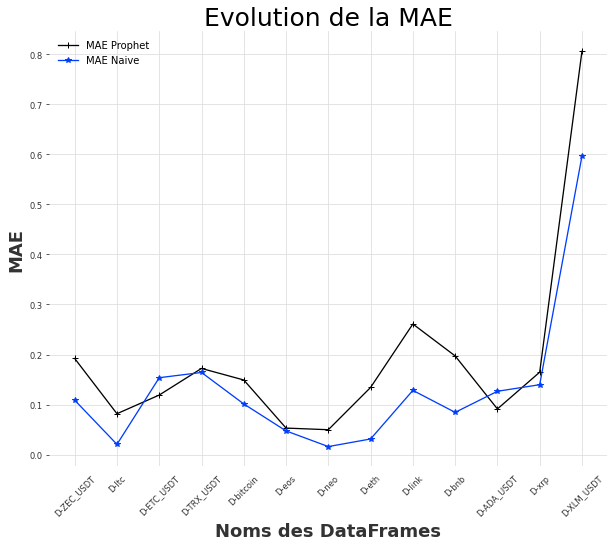

In [14]:
figure(figsize=(10, 8))
plt.axes()

liste_MAE1_prophet = results_prophet["MAE"].tolist()
liste_MAE_prophet = [float(item) for item in liste_MAE1_prophet]

liste_MAE1_naive = results_naive["MAE"].tolist()
liste_MAE_naive = [float(item) for item in liste_MAE1_naive]

x = np.array([0,1,2,3,4,5,6,7,8,9,10,11,12])
y = np.array(liste_MAE_prophet)
y2 = np.array(liste_MAE_naive)

liste_NAME = results_prophet["DATA_SET_NAME"].tolist()
my_xticks = liste_NAME
plt.xticks(x, my_xticks)
plt.xticks(rotation=45)
plt.plot(x, y, label = 'MAE Prophet', marker="+")
plt.plot(x, y2, label = 'MAE Naive', marker="*")
plt.title("Evolution de la MAE",fontsize=25)
plt.xlabel("Noms des DataFrames",fontsize=18)
plt.ylabel("MAE",fontsize=18)
plt.legend()
plt.show()

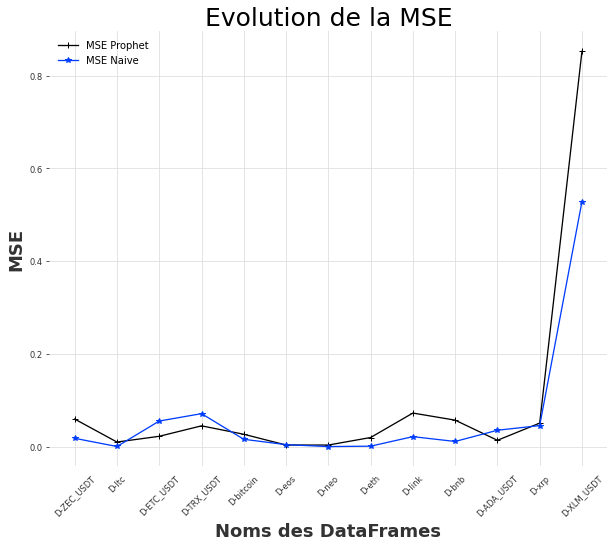

In [15]:
figure(figsize=(10, 8))
plt.axes()

liste_MSE1_prophet = results_prophet["MSE"].tolist()
liste_MSE_prophet = [float(item) for item in liste_MSE1_prophet]

liste_MSE1_naive = results_naive["MSE"].tolist()
liste_MSE_naive = [float(item) for item in liste_MSE1_naive]

x = np.array([0,1,2,3,4,5,6,7,8,9,10,11,12])
y = np.array(liste_MSE_prophet)
y2 = np.array(liste_MSE_naive)

liste_NAME = results_prophet["DATA_SET_NAME"].tolist()
my_xticks = liste_NAME
plt.xticks(x, my_xticks)
plt.xticks(rotation=45)
plt.plot(x, y, label = 'MSE Prophet', marker="+")
plt.plot(x, y2, label = 'MSE Naive', marker="*")
plt.title("Evolution de la MSE",fontsize=25)
plt.xlabel("Noms des DataFrames",fontsize=18)
plt.ylabel("MSE",fontsize=18)
plt.legend()
plt.show()

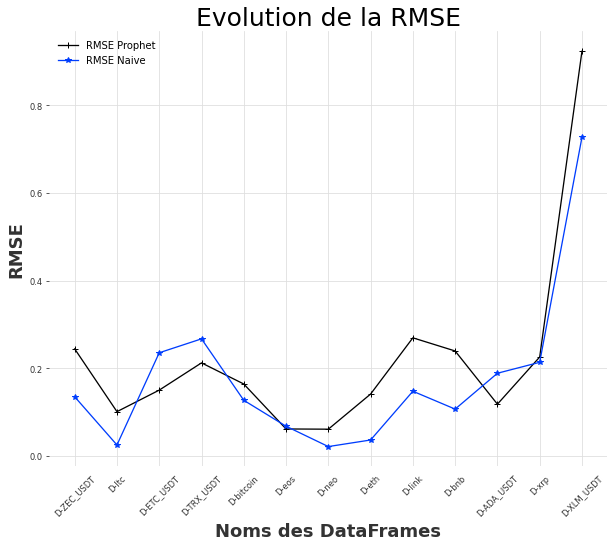

In [16]:
figure(figsize=(10, 8))
plt.axes()

liste_RMSE1_prophet = results_prophet["RMSE"].tolist()
liste_RMSE_prophet = [float(item) for item in liste_RMSE1_prophet]

liste_RMSE1_naive = results_naive["RMSE"].tolist()
liste_RMSE_naive = [float(item) for item in liste_RMSE1_naive]

x = np.array([0,1,2,3,4,5,6,7,8,9,10,11,12])
y = np.array(liste_RMSE_prophet)
y2 = np.array(liste_RMSE_naive)

liste_NAME = results_prophet["DATA_SET_NAME"].tolist()
my_xticks = liste_NAME
plt.xticks(x, my_xticks)
plt.xticks(rotation=45)
plt.plot(x, y, label = 'RMSE Prophet', marker="+")
plt.plot(x, y2, label = 'RMSE Naive', marker="*")
plt.title("Evolution de la RMSE",fontsize=25)
plt.xlabel("Noms des DataFrames",fontsize=18)
plt.ylabel("RMSE",fontsize=18)
plt.legend()
plt.show()

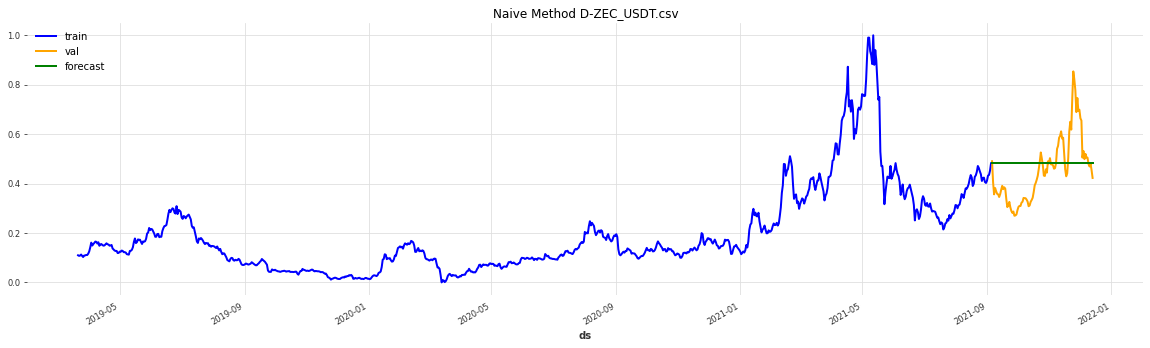

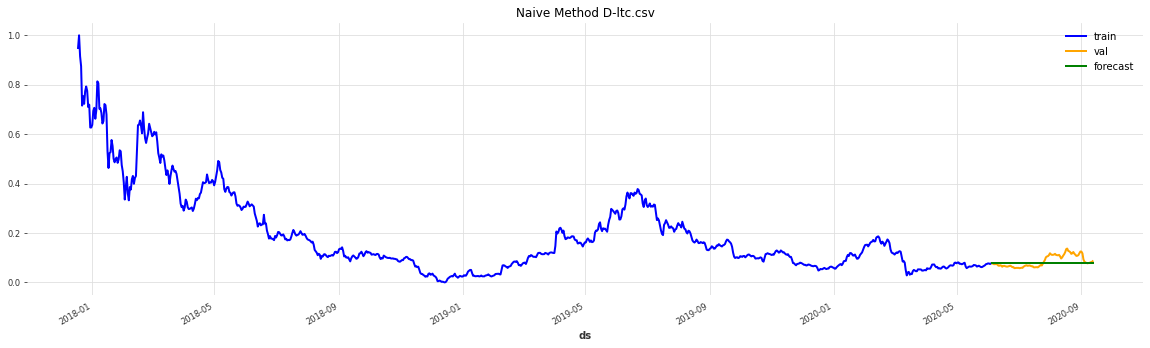

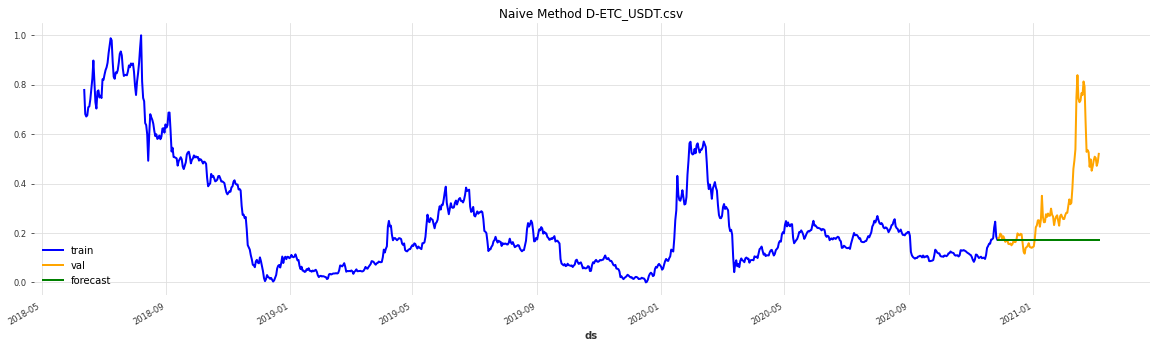

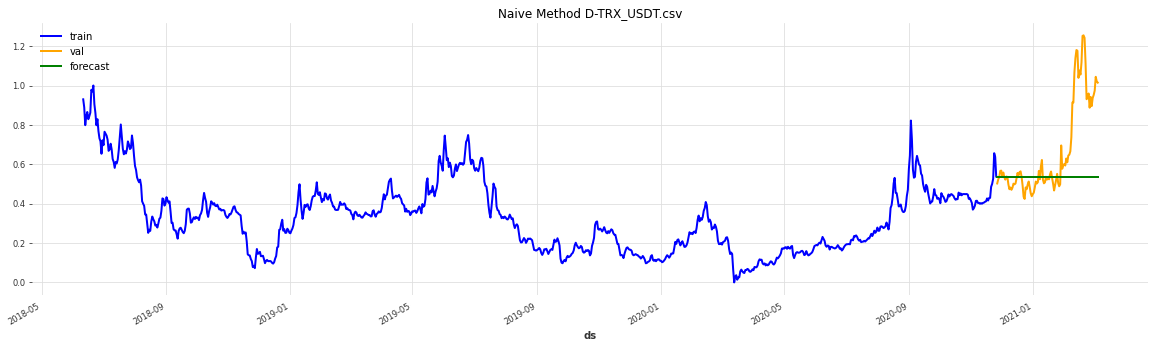

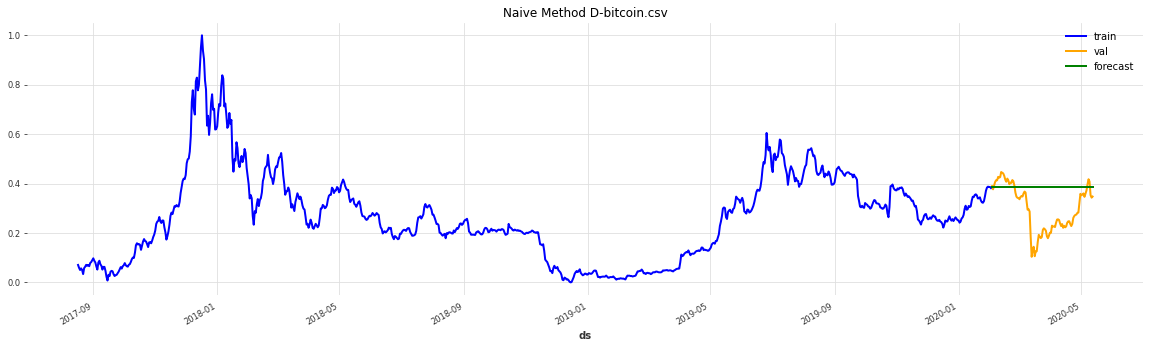

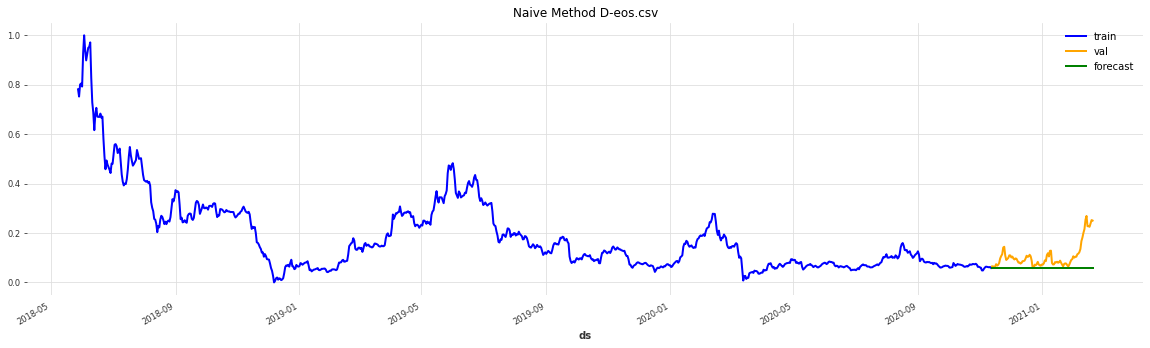

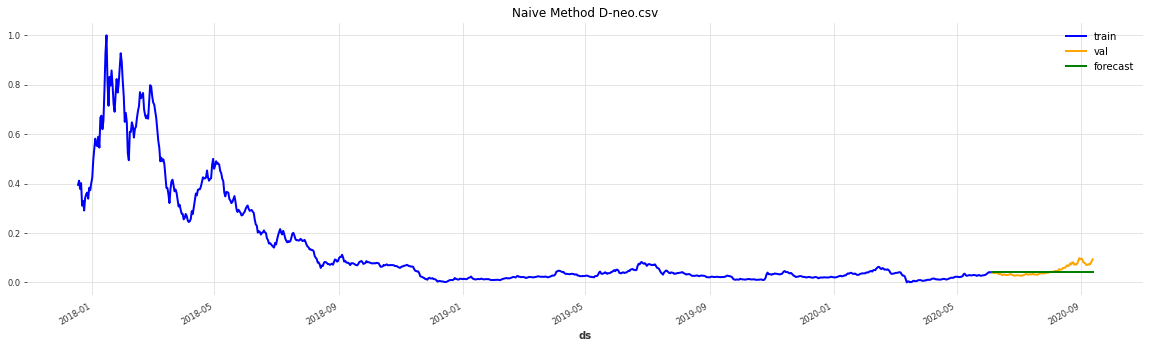

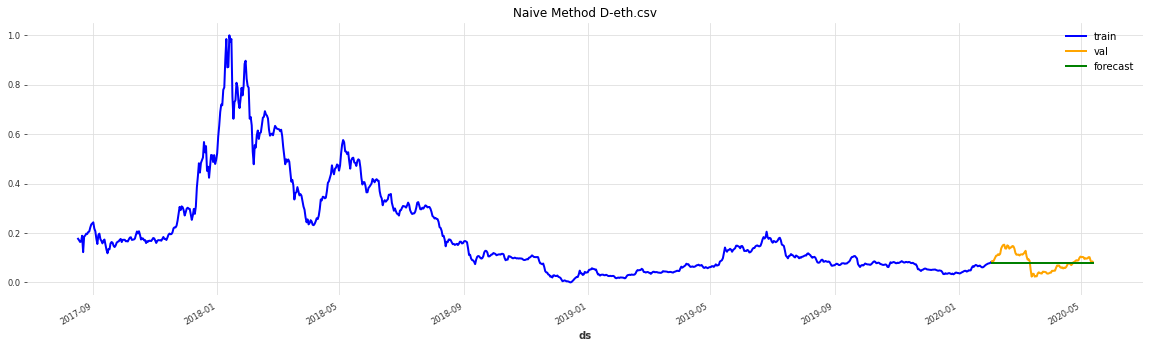

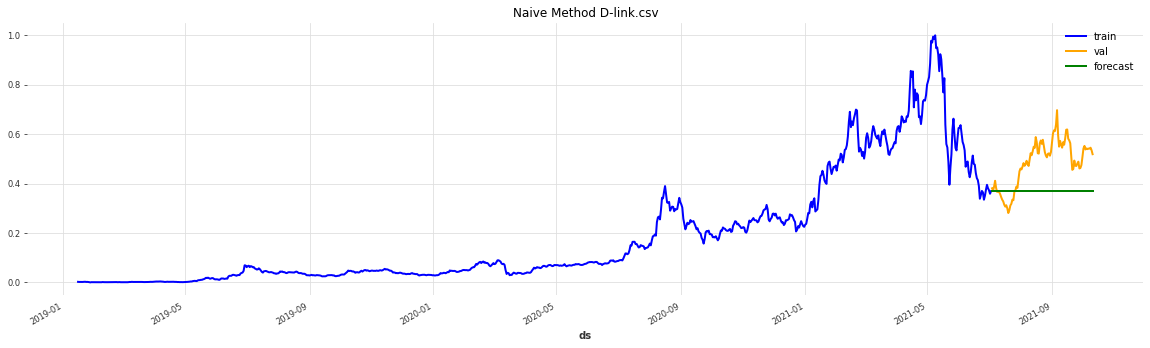

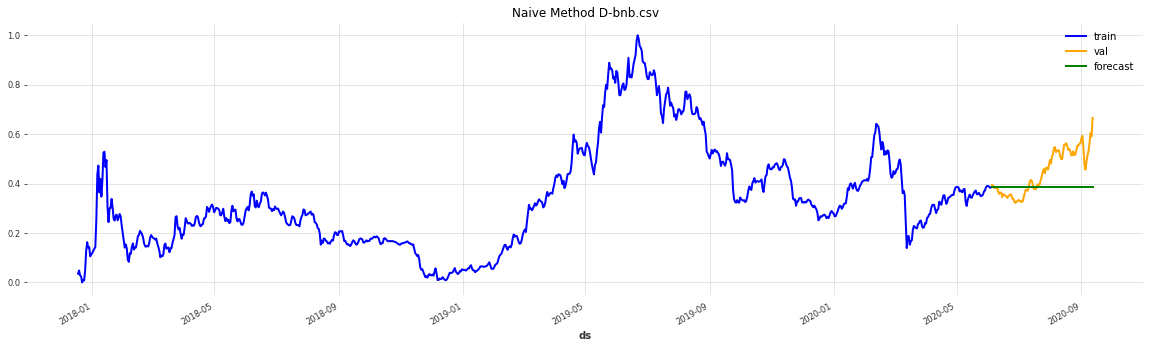

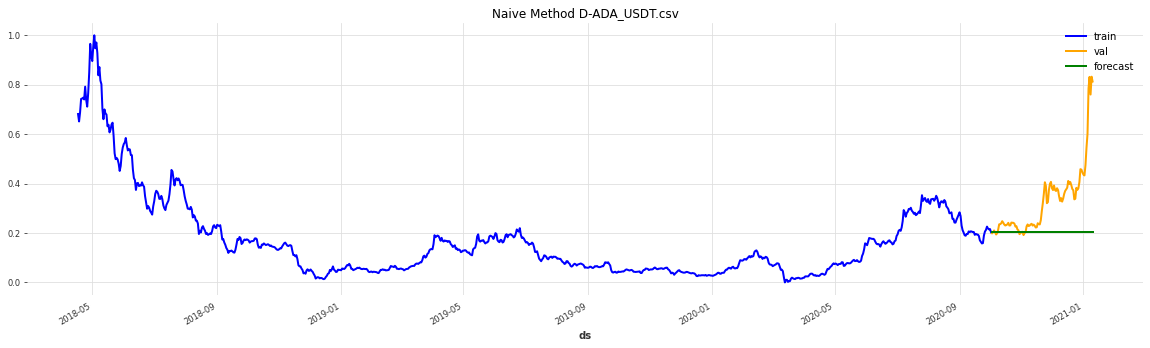

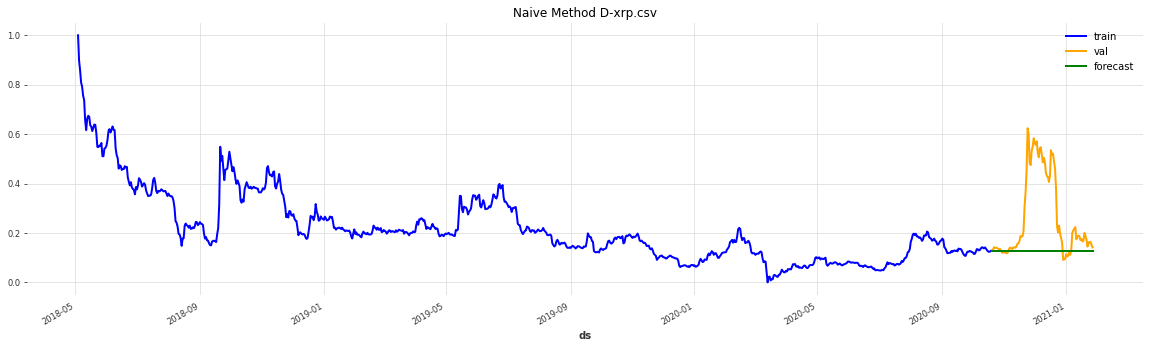

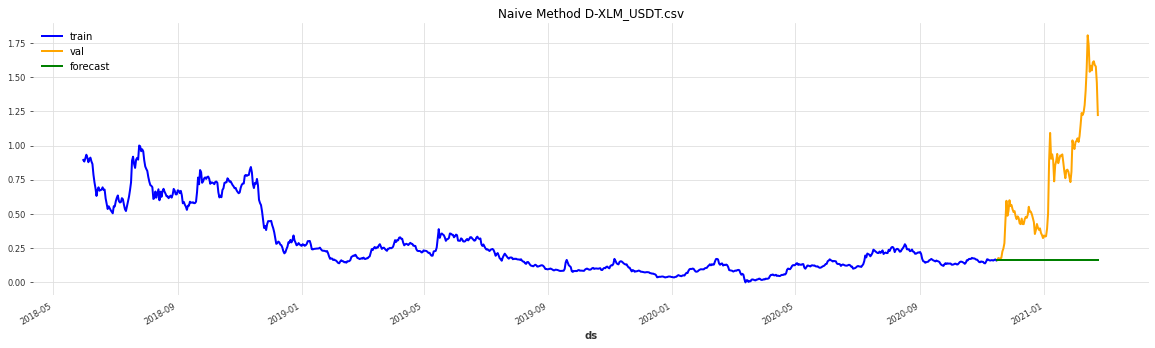

In [17]:
for i in range(len(df_fit_naive)):
    plt.figure(figsize=(20,5))
    df_fit_naive[i].plot(color ='blue', label="train")
    df_true_prediction_naive[i].plot(color ='orange', label="val")
    forecast_naive[i].plot(color ='green',label="forecast")
    plt.title('Naive Method '+file_name[i]+".csv")    
    plt.legend(loc='best')
    plt.show()

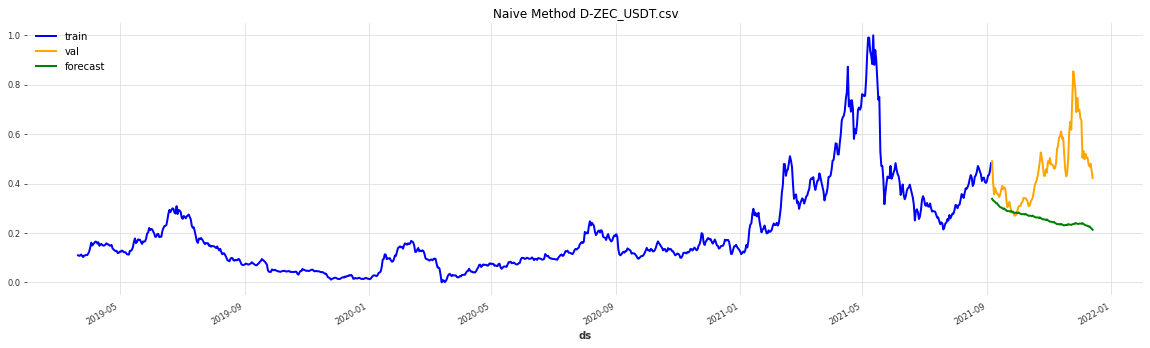

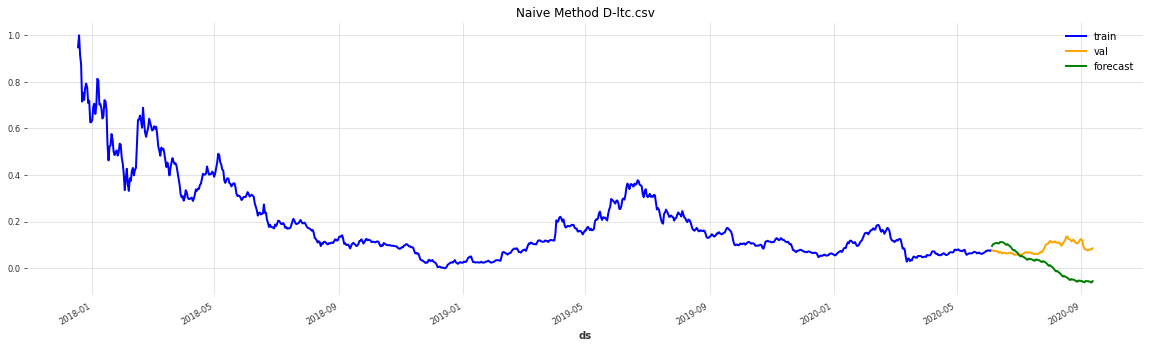

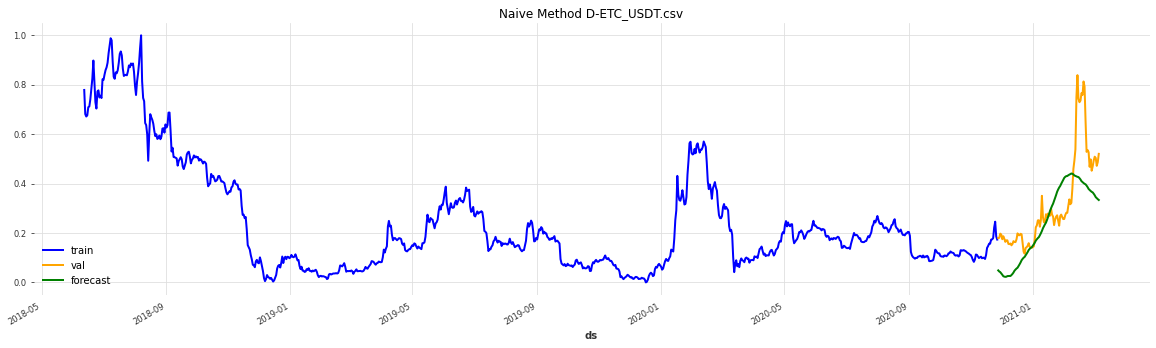

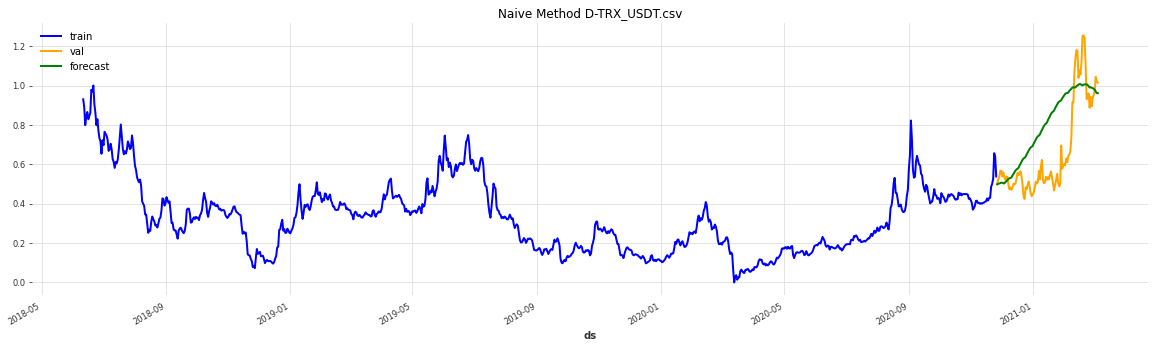

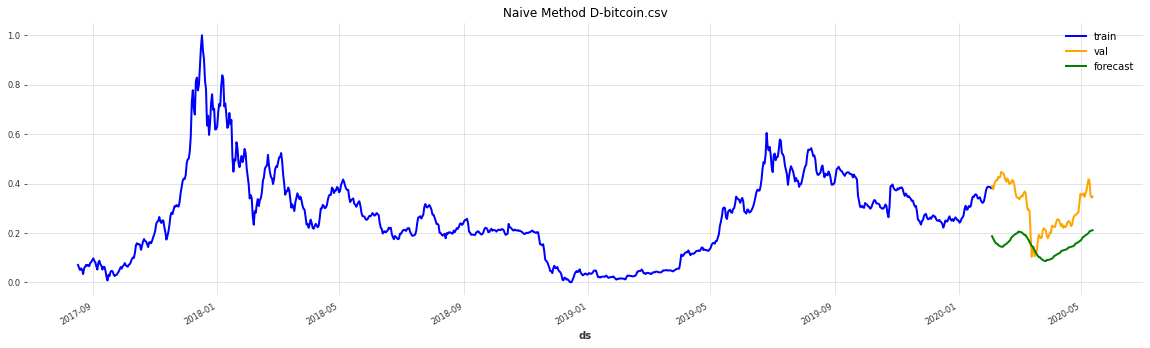

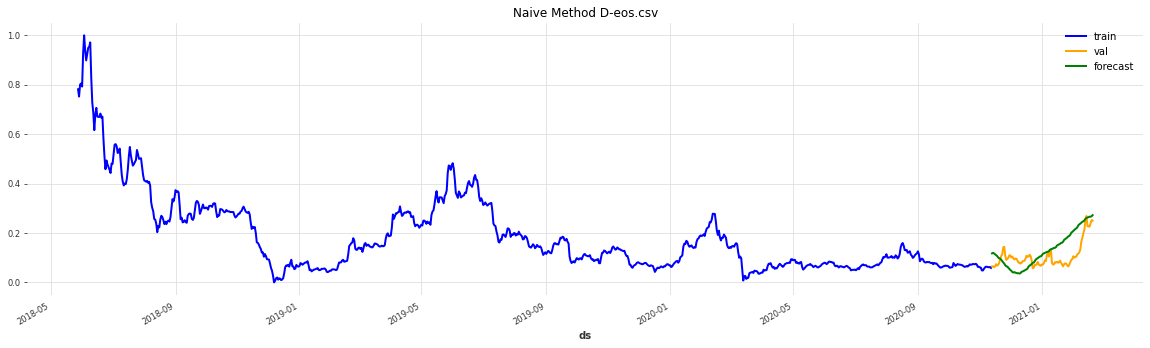

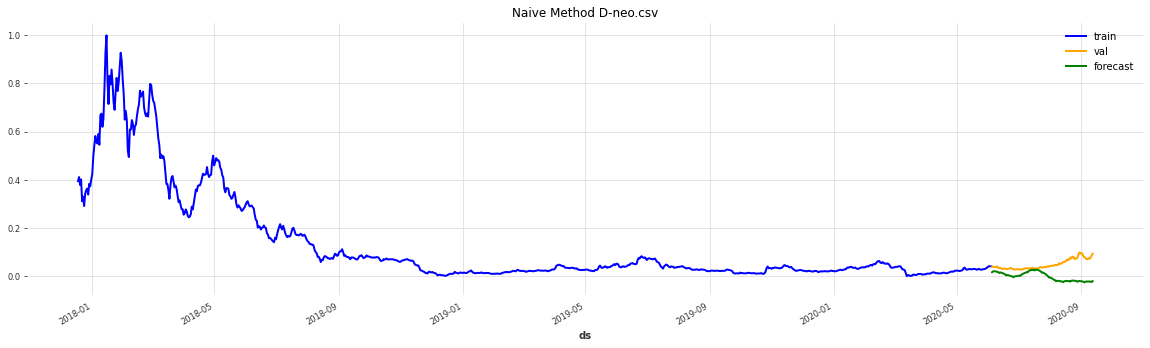

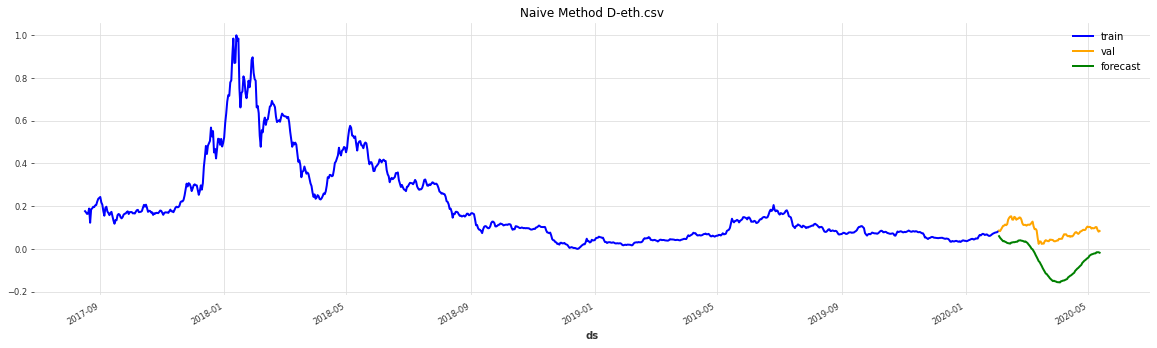

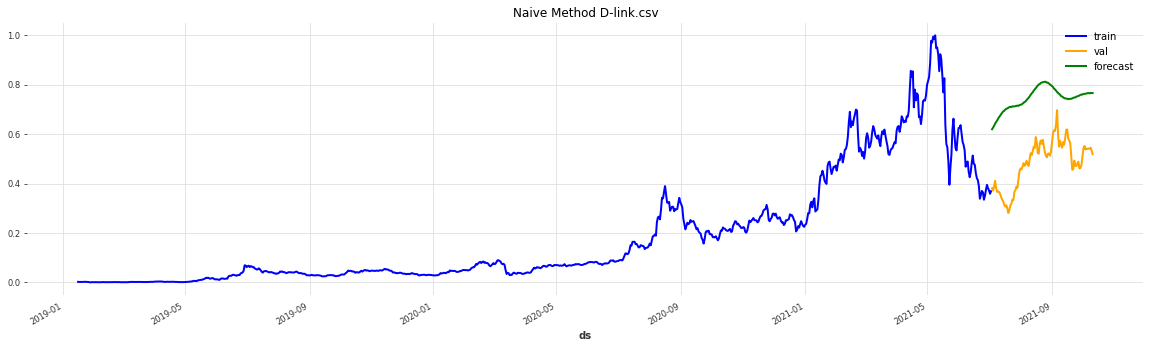

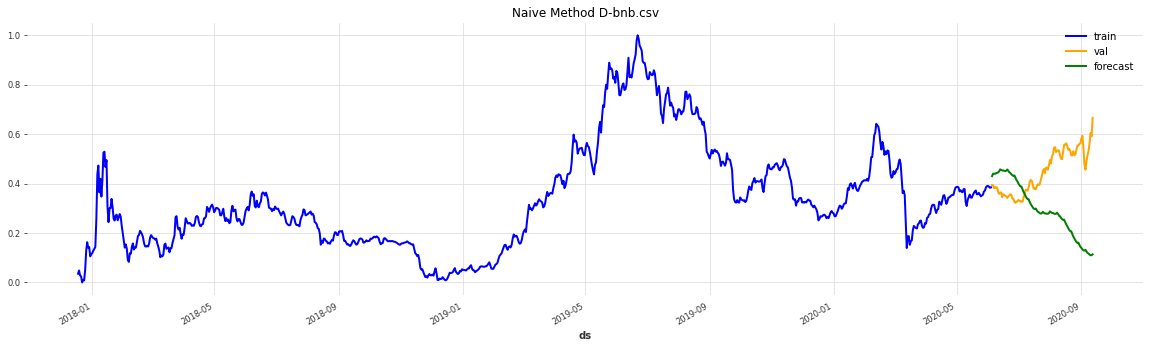

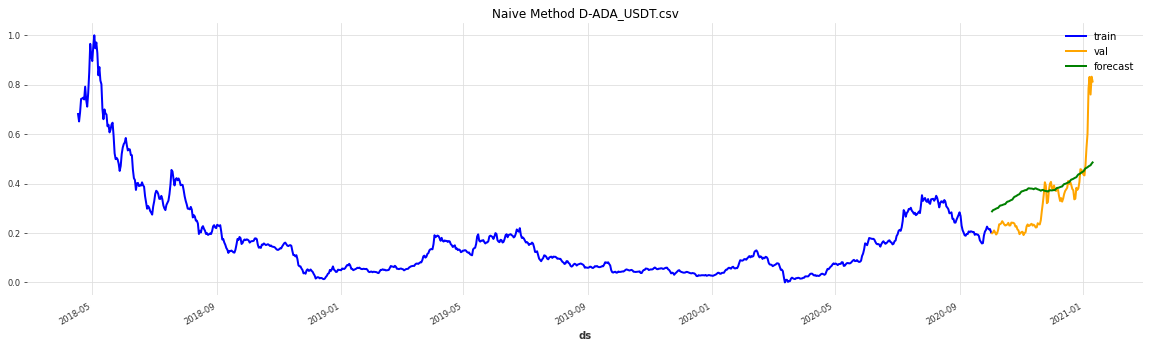

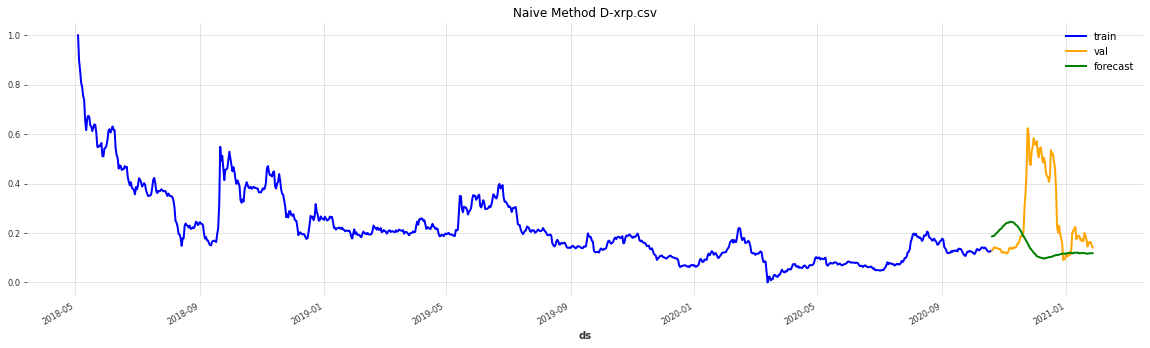

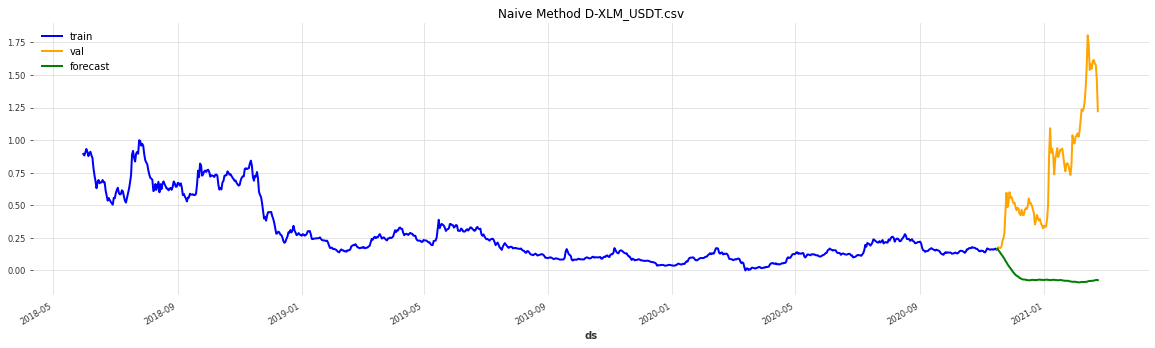

In [18]:
for i in range(len(df_fit_prophet)):
    plt.figure(figsize=(20,5))
    df_fit_prophet[i].plot(color ='blue', label="train")
    df_true_prediction_prophet[i].plot(color ='orange', label="val")
    forecast_prophet[i].plot(color ='green',label="forecast")
    plt.title('Naive Method '+file_name[i]+".csv")    
    plt.legend(loc='best')
    plt.show()

In [ ]:
for i in range(len(df_fit_naive)):
    if len(df_fit_naive[i]) != 900 :
        print("ERROR, len(df_fit_naive[{}]) = {}".format(i, len(df_fit_naive[i])))
    elif len(df_true_prediction_naive[i]) != 100 :
        print("ERROR, len(df_true_prediction_naive[{}]) = {}".format(i, len(df_true_prediction_naive[i])))
    else:
        print("Tout est bon pour data i = ", i)
    print("-----")

Tout est bon pour data i =  0
-----
Tout est bon pour data i =  1
-----
Tout est bon pour data i =  2
-----
Tout est bon pour data i =  3
-----
Tout est bon pour data i =  4
-----
Tout est bon pour data i =  5
-----
Tout est bon pour data i =  6
-----
Tout est bon pour data i =  7
-----
Tout est bon pour data i =  8
-----
Tout est bon pour data i =  9
-----
Tout est bon pour data i =  10
-----
Tout est bon pour data i =  11
-----
Tout est bon pour data i =  12
-----


In [ ]:
for i in range(len(df_fit_prophet)):
    if len(df_fit_prophet[i]) != 900 :
        print("ERROR, len(df_fit_prophet[{}] = {}".format(i, len(df_fit_prophet[i])))
    elif len(df_true_prediction_prophet[i]) != 100 :
        print("ERROR, len(df_true_prediction_prophet[{}] = {}".format(i, len(df_true_prediction_prophet[i])))
    else:
        print("Tout est bon pour data i = ", i)
    print("-----")